In [12]:
import os
from collections import Counter, OrderedDict

from xml.etree import ElementTree as ET

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

import torchvision
from torchvision import transforms
from torchvision.transforms import functional as T

from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

import numpy as np
import matplotlib.pyplot as plt

import cv2

import PIL

from tqdm.auto import tqdm

In [13]:
diatom_dataset_root_dir = os.path.join("..", "data", "diatom_dataset")

diatom_images_dir = os.path.join(diatom_dataset_root_dir, "images")
diatom_xmls_dir = os.path.join(diatom_dataset_root_dir, "xmls")

In [14]:
def parse_xml(filename):
  tree = ET.parse(os.path.join(diatom_xmls_dir, filename))
  root = tree.getroot()

  filename = root.find("filename").text + ".png"

  width = int(root.find("size/width").text)
  height = int(root.find("size/height").text)

  objs = []

  for obj in root.findall("objects/object"):
    class_id = int(obj.find("id").text)
    class_name = obj.find("name").text

    xmin = int(obj.find("bbox/xmin").text)
    xmax = int(obj.find("bbox/xmax").text)
    ymin = int(obj.find("bbox/ymin").text)
    ymax = int(obj.find("bbox/ymax").text)

    objs.append({
      "class_id": class_id,
      "class_name": class_name,
      "xmin": xmin,
      "xmax": xmax,
      "ymin": ymin,
      "ymax": ymax,
    })

  return {
    "filename": filename,
    "width": width,
    "height": height,
    "objects": objs
  }

parse_xml("25.xml")

{'filename': '25.png',
 'width': 2112,
 'height': 1584,
 'objects': [{'class_id': 142,
   'class_name': 'Gomphonema drutelingense',
   'xmin': 604,
   'xmax': 874,
   'ymin': 1101,
   'ymax': 1248},
  {'class_id': 1,
   'class_name': 'Cymbella cantonatii',
   'xmin': 648,
   'xmax': 1227,
   'ymin': 839,
   'ymax': 1116}]}

In [15]:
class DiatomDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.transform = transform

    self.xml_dir = os.path.join(self.root_dir, "xmls")
    self.image_dir = os.path.join(self.root_dir, "images")

    self.xml_files = os.listdir(self.xml_dir)
    self.xmls = [parse_xml(xml_file) for xml_file in self.xml_files]
    self.xmls = [xml for xml in self.xmls if len(xml["objects"]) > 0]

    class_counter = Counter(obj["class_name"] for xml in self.xmls for obj in xml["objects"])

    sorted_items = sorted(class_counter.items(), key=lambda x: x[1], reverse=True)
    
    self.class_to_idx = {class_name: i + 1 for i, (class_name, _) in enumerate(sorted_items)}
    self.classes = {class_id: class_name for class_name, class_id in self.class_to_idx.items()}

  def __len__(self):
    return len(self.xmls)

  def __getitem__(self, index):
    assert 0 <= index << self.__len__()
    
    xml = self.xmls[index]

    image_filename = os.path.join(self.image_dir, xml["filename"])

    image = PIL.Image.open(image_filename).convert("RGB")
    if self.transform:
      image = self.transform(image)
    
    boxes, labels = zip(*[
      (
        (*self._extract_bndbox(obj),), self.class_to_idx[obj["class_name"]]
      ) for obj in xml["objects"]
    ])

    target = {
      "boxes": torch.tensor(boxes, dtype=torch.float32),
      "labels": torch.tensor(labels, dtype=torch.int64),
    }

    return image, target
  
  def _extract_bndbox(self, obj):
    return obj["xmin"], obj["ymin"], obj["xmax"], obj["ymax"]

In [16]:
diatom_dataset = DiatomDataset(diatom_dataset_root_dir)

image, target = diatom_dataset[0]
image.size, target

((2112, 1584),
 {'boxes': tensor([[ 784., 1118.,  887., 1300.]]), 'labels': tensor([32])})

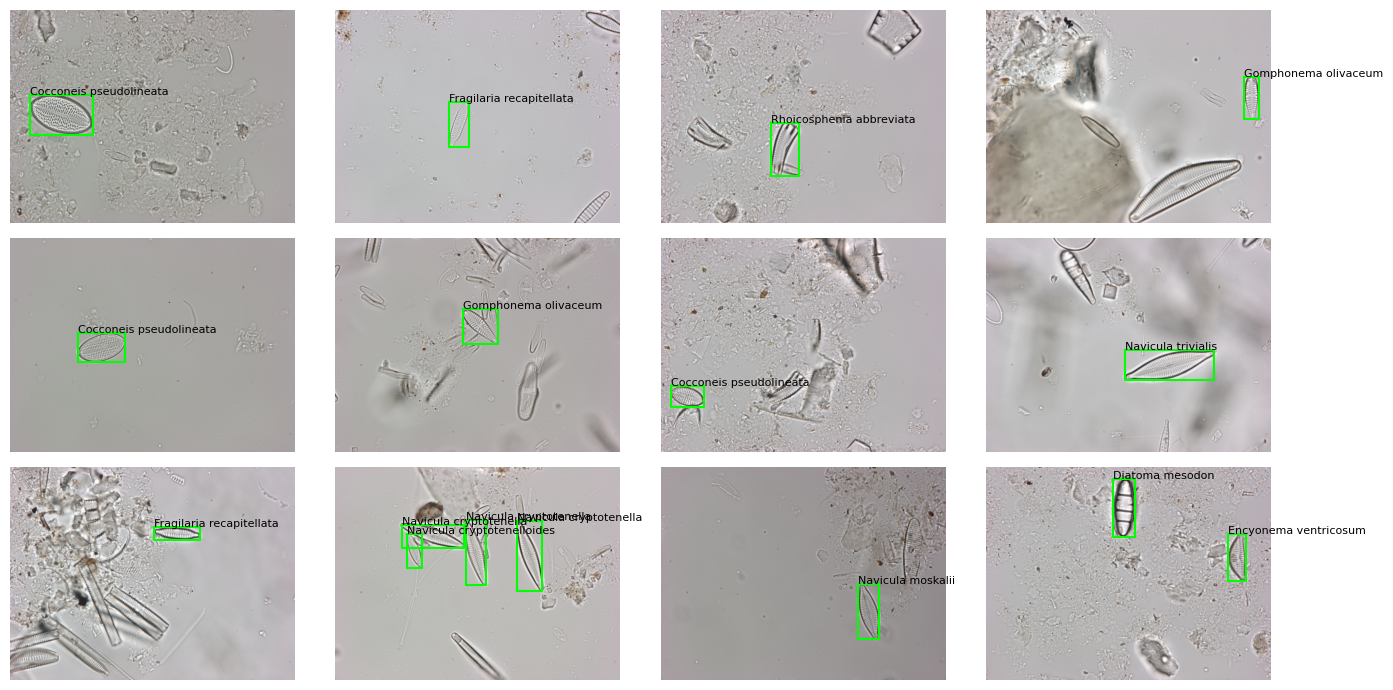

In [17]:
def plot_random_samples(dataset, n_rows=3, n_cols=4):
  n_samples = n_rows * n_cols

  sample_indices = np.random.choice(len(dataset), n_samples)

  plt.figure(figsize=(14, 7))

  for i in range(n_samples):
    image, target = dataset[sample_indices[i]]
    labels = [dataset.classes[label.cpu().item()] for label in target["labels"]]

    plt.subplot(n_rows, n_cols, i + 1)

    plt.imshow(image)
    plt.axis(False)

    for j, box in enumerate(target["boxes"]):
      xmin, ymin, xmax, ymax = box.cpu().numpy()

      plt.plot(
        [xmin, xmax, xmax, xmin, xmin],
        [ymin, ymin, ymax, ymax, ymin],
        color="lime"
      )
      plt.text(xmin, ymin, labels[j], color="black", fontsize=8)


  plt.tight_layout()
  plt.show()

plot_random_samples(diatom_dataset)

In [18]:
class_counter = Counter(label.cpu().item() for _, target in tqdm(diatom_dataset) for label in target["labels"])

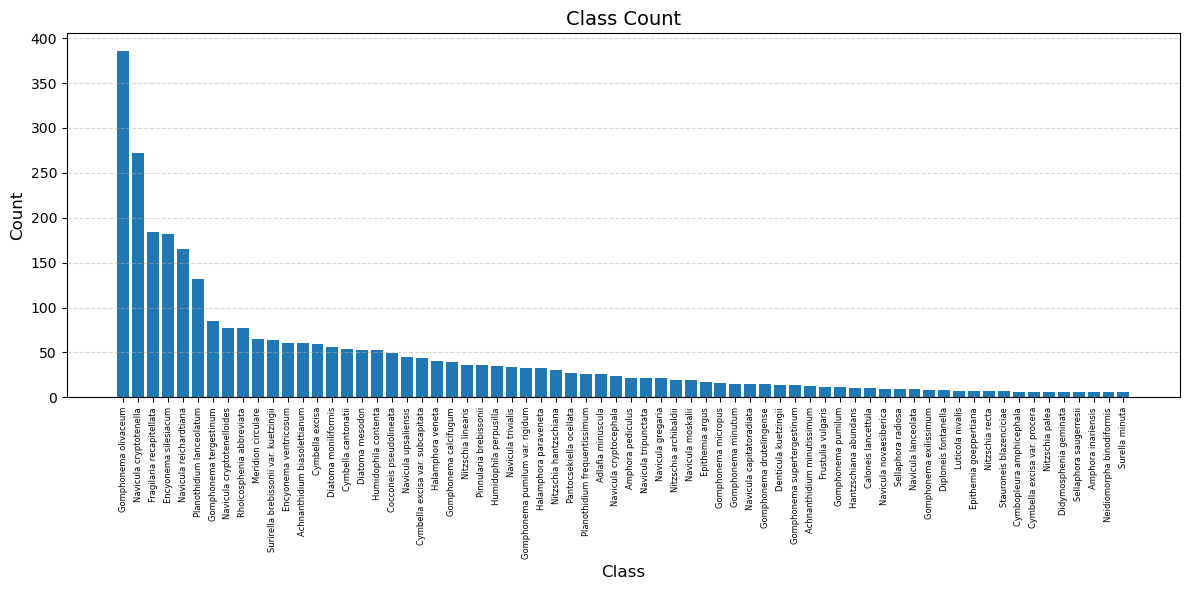

In [19]:
sorted_items = sorted(class_counter.items(), key=lambda x: x[1], reverse=True)
sorted_keys, sorted_values = zip(*sorted_items)

plt.figure(figsize=(12, 6))
plt.bar(sorted_keys, sorted_values)

plt.title("Class Count", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.5)

xticks = range(1, len(sorted_keys)+1)
xtick_labels = [diatom_dataset.classes[x] for x in xticks]

plt.xticks(xticks, xtick_labels, rotation=90, fontsize=6)

plt.tight_layout()
plt.show()

In [21]:
len(diatom_dataset)

2184